# How to Train YOLOv10 on a Custom Dataset

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Mon Jun 24 08:23:55 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [1]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Clone and Install

**NOTE:** YOLOv9 is very new. At the moment, we recommend using a fork of the main repository. The `detect.py` script contains a bug that prevents inference. This bug is patched in the fork.

In [2]:
!git clone https://github.com/THU-MIG/yolov10.git
%cd yolov10
!pip install -r requirements.txt -q

Cloning into 'yolov10'...
remote: Enumerating objects: 20304, done.
remote: Counting objects: 100% (1347/1347), done.
remote: Compressing objects: 100% (127/127), done.
remote: Total 20304 (delta 1301), reused 1224 (delta 1220), pack-reused 18957
Receiving objects: 100% (20304/20304), 11.18 MiB | 11.81 MiB/s, done.
Resolving deltas: 100% (14304/14304), done.
/content/yolov10
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 MB 2.

**NOTE:** Let's install the [`roboflow`](https://pypi.org/project/roboflow) package, which we will use to download our dataset from [Roboflow Universe](https://universe.roboflow.com/).

In [3]:
!pip install -q roboflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 911.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.5 MB/s eta 0:00:00


## Libraries

In [4]:
import os
import shutil

## Download model weights

In [5]:
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10n.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10s.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10m.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10b.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10l.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10x.pt

In [6]:
!ls -lahS {HOME}/weights

total 408M
-rw-r--r-- 1 root root 123M May 26 15:54 yolov10x.pt
-rw-r--r-- 1 root root 100M May 26 15:53 yolov10l.pt
-rw-r--r-- 1 root root  80M May 26 15:53 yolov10b.pt
-rw-r--r-- 1 root root  64M May 26 15:54 yolov10m.pt
-rw-r--r-- 1 root root  32M May 26 15:54 yolov10s.pt
-rw-r--r-- 1 root root  11M May 26 15:54 yolov10n.pt
drwxr-xr-x 2 root root 4.0K Jun 24 11:08 .
drwxr-xr-x 1 root root 4.0K Jun 24 11:08 ..


## Download example data

**NOTE:** If you want to run inference using your own file as input, simply upload image to Google Colab and update `SOURCE_IMAGE_PATH` with the path leading to your file.

In [7]:
!wget -P {HOME}/data -q https://media.roboflow.com/notebooks/examples/dog.jpeg

In [8]:
SOURCE_IMAGE_PATH = f"{HOME}/data/dog.jpeg"

## Detection with pre-trained model

In [9]:
# !python detect.py --weights {HOME}/weights/gelan-c.pt --conf 0.1 --source {HOME}/data/dog.jpeg --device 0

In [10]:
from ultralytics import YOLOv10

In [11]:
model = YOLOv10('/content/weights/yolov10s.pt')

In [12]:
results = model.predict(SOURCE_IMAGE_PATH)


image 1/1 /content/data/dog.jpeg: 640x384 1 person, 1 car, 2 dogs, 1 backpack, 414.8ms
Speed: 18.1ms preprocess, 414.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 384)


In [13]:
# path to save the predictions
results_path = f"{HOME}/yolov10/runs/detect/exp/"
os.makedirs(results_path, exist_ok=True)
# Display the results
results[0].save(os.path.join(results_path, "dog.jpeg"))

'/content/yolov10/runs/detect/exp/dog.jpeg'

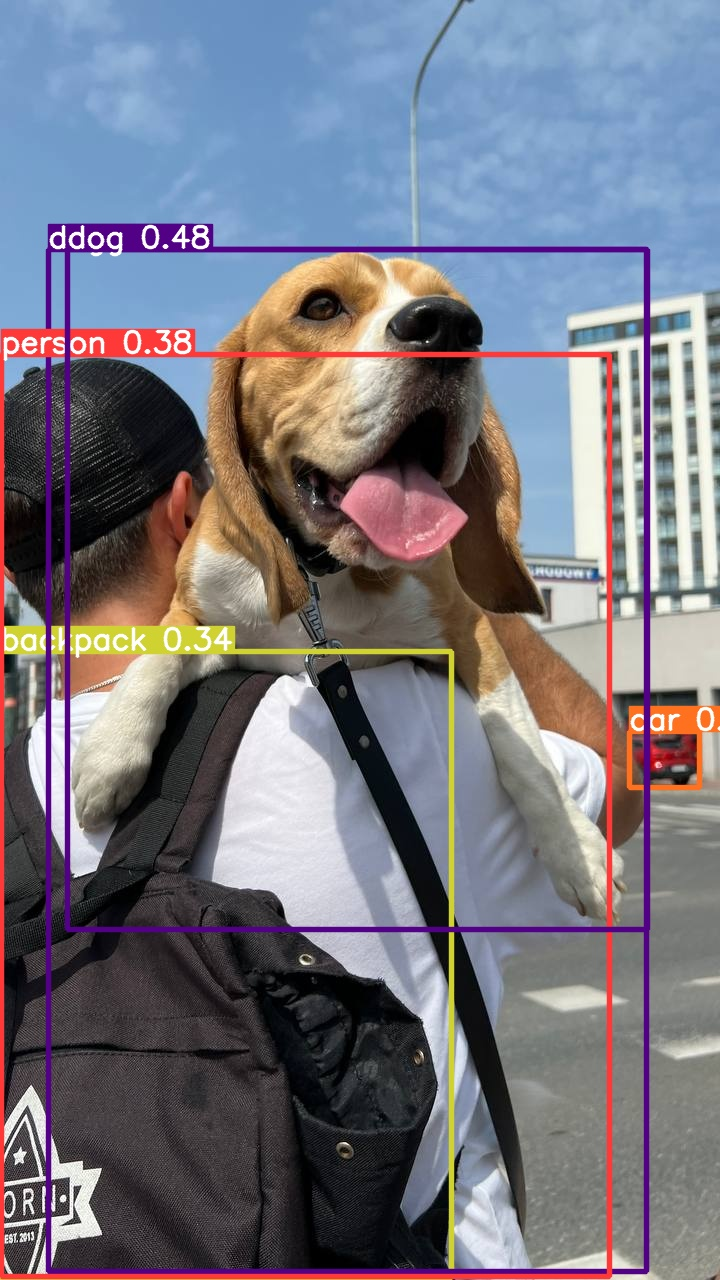

In [14]:
from IPython.display import Image

Image(filename=f"{HOME}/yolov10/runs/detect/exp/dog.jpeg", width=600)

## Authenticate and Download the Dataset

**NOTE:** The dataset must be saved inside the `{HOME}/yolov9` directory, otherwise, the training will not succeed.

In [15]:
%cd {HOME}/yolov10

/content/yolov10


In [16]:
from roboflow import Roboflow
rf = Roboflow(api_key="")
project = rf.workspace("roboflow-jvuqo").project("football-players-detection-3zvbc")
version = project.version(9)
dataset = version.download("yolov9")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to football-players-detection-9 in yolov9:: 100%|██████████| 636/636 [00:00<00:00, 1856.33it/s]


## Train Custom Model

In [17]:
!pip -q install pyyaml

In [18]:
import yaml

# Function to read a YAML file
def read_yaml(file_path):
    with open(file_path, 'r') as file:
        return yaml.safe_load(file)

# Function to write to a YAML file
def write_yaml(file_path, data):
    with open(file_path, 'w') as file:
        yaml.dump(data, file, default_flow_style=False)

In [19]:
file_path = f'{dataset.location}/data.yaml'

# Read the YAML file
data = read_yaml(file_path)

In [20]:
data['val'] = f'{dataset.location}/valid/images'
data['train'] = f'{dataset.location}/train/images'

In [21]:
write_yaml(file_path, data)

In [29]:
from ultralytics import YOLOv10

model = YOLOv10('/content/weights/yolov10s.pt')

model.train(data=f'{dataset.location}/data.yaml', epochs=25, batch=16, imgsz=640)

New https://pypi.org/project/ultralytics/8.2.41 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.10.12 torch-2.0.1+cu117 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/content/weights/yolov10s.pt, data=/content/yolov10/football-players-detection-9/data.yaml, epochs=25, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, cla

100%|██████████| 755k/755k [00:00<00:00, 19.7MB/s]


Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1     36096  ultralytics.nn.modules.block.SCDown          [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1    137728  ultralytics

100%|██████████| 6.23M/6.23M [00:00<00:00, 124MB/s]


AMP: checks passed ✅


train: Scanning /content/yolov10/football-players-detection-9/train/labels... 250 images, 0 backgrounds, 0 corrupt: 100%|██████████| 250/250 [00:00<00:00, 1663.70it/s]

train: New cache created: /content/yolov10/football-players-detection-9/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
val: Scanning /content/yolov10/football-players-detection-9/valid/labels... 43 images, 0 backgrounds, 0 corrupt: 100%|██████████| 43/43 [00:00<00:00, 958.38it/s]

val: New cache created: /content/yolov10/football-players-detection-9/valid/labels.cache


Plotting labels to /content/yolov10/runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 99 weight(decay=0.0), 112 weight(decay=0.0005), 111 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/yolov10/runs/detect/train2
Starting training for 25 epochs...

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       1/25      6.07G      1.625      3.352     0.9005      1.844      5.321     0.8761        296        640: 100%|██████████| 16/16 [00:25<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.68s/it]

                   all         43       1025      0.931      0.196        0.2      0.121



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       2/25      5.92G      1.504       1.21     0.8443      1.707      2.229     0.8369        392        640: 100%|██████████| 16/16 [00:07<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.63it/s]

                   all         43       1025      0.957      0.212      0.235      0.129



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       3/25      6.03G      1.465      1.018      0.837      1.647      1.506     0.8309        436        640: 100%|██████████| 16/16 [00:09<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.41it/s]

                   all         43       1025      0.433      0.307      0.275       0.16



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       4/25      6.05G      1.363        0.9      0.834      1.568      1.198     0.8281        370        640: 100%|██████████| 16/16 [00:11<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.75it/s]

                   all         43       1025      0.527      0.319      0.283      0.158



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       5/25      5.95G       1.32      0.824     0.8308      1.512       1.04     0.8238        381        640: 100%|██████████| 16/16 [00:08<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.87it/s]

                   all         43       1025      0.553      0.415      0.323      0.177



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       6/25      5.79G       1.41     0.8107     0.8318      1.612     0.9628      0.828        588        640: 100%|██████████| 16/16 [00:07<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.38it/s]

                   all         43       1025      0.755      0.309      0.389      0.229



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       7/25      6.17G      1.371     0.8081     0.8334      1.604     0.9168     0.8285        437        640: 100%|██████████| 16/16 [00:11<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.92it/s]

                   all         43       1025      0.697       0.43      0.486      0.287



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       8/25      6.49G      1.329     0.7739     0.8246      1.518     0.8667     0.8204        327        640: 100%|██████████| 16/16 [00:11<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.45it/s]

                   all         43       1025      0.577      0.441      0.364      0.229



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       9/25      5.77G      1.257      0.715     0.8246      1.463     0.7966     0.8235        419        640: 100%|██████████| 16/16 [00:12<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.51it/s]

                   all         43       1025      0.576      0.519      0.406       0.24



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      10/25      6.29G      1.263     0.7102     0.8215      1.494     0.7684      0.819        436        640: 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.32it/s]

                   all         43       1025      0.747      0.493      0.522      0.327



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      11/25      6.09G      1.218      0.667     0.8201      1.426     0.7053     0.8169        386        640: 100%|██████████| 16/16 [00:10<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.22it/s]

                   all         43       1025      0.763      0.496      0.597      0.369



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      12/25       5.6G       1.18     0.6401     0.8183      1.387     0.6905     0.8157        351        640: 100%|██████████| 16/16 [00:11<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.71it/s]

                   all         43       1025      0.644      0.646      0.615      0.374



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      13/25      5.97G      1.208     0.6229     0.8182      1.432     0.6615     0.8137        505        640: 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.53it/s]

                   all         43       1025      0.748        0.6      0.652        0.4



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      14/25      6.01G      1.197     0.6271     0.8092      1.407     0.6783     0.8067        264        640: 100%|██████████| 16/16 [00:07<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.46it/s]

                   all         43       1025       0.83       0.63      0.691      0.427



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      15/25      5.77G      1.161     0.6016     0.8145      1.372      0.631      0.813        543        640: 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.46it/s]

                   all         43       1025      0.797      0.636      0.689      0.424


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      16/25      5.51G      1.072     0.5894     0.8124      1.264     0.6263     0.8139        230        640: 100%|██████████| 16/16 [00:20<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.51it/s]

                   all         43       1025      0.782      0.501       0.63      0.379



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      17/25      5.35G      1.032     0.5583     0.8077      1.228     0.5831     0.8111        233        640: 100%|██████████| 16/16 [00:10<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.46it/s]

                   all         43       1025      0.773      0.603      0.661       0.39



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      18/25      5.34G      1.019     0.5474     0.8031      1.214     0.5782     0.8065        230        640: 100%|██████████| 16/16 [00:08<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.53it/s]

                   all         43       1025      0.828      0.599      0.661      0.407



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      19/25      5.34G     0.9838     0.5279     0.8037      1.177     0.5423     0.8038        234        640: 100%|██████████| 16/16 [00:07<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.53it/s]

                   all         43       1025      0.743      0.641      0.687      0.419



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      20/25      5.35G      1.017     0.5305     0.8072      1.229     0.5558     0.8083        224        640: 100%|██████████| 16/16 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.90it/s]

                   all         43       1025      0.784      0.643        0.7      0.431



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      21/25      5.34G     0.9567     0.5005     0.8036      1.155     0.5126     0.8042        229        640: 100%|██████████| 16/16 [00:08<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.71it/s]

                   all         43       1025      0.773      0.609      0.681      0.419



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      22/25      5.34G      0.965      0.497     0.8063      1.148     0.5083     0.8081        234        640: 100%|██████████| 16/16 [00:07<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.47it/s]

                   all         43       1025      0.788      0.688      0.716      0.452



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      23/25      5.34G     0.9421     0.4933     0.8026      1.141     0.5064     0.8059        230        640: 100%|██████████| 16/16 [00:10<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.33it/s]

                   all         43       1025      0.784      0.663      0.717      0.455



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      24/25      5.34G     0.9338      0.479     0.7985      1.132     0.4937     0.8019        231        640: 100%|██████████| 16/16 [00:09<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.48it/s]

                   all         43       1025      0.786      0.658      0.713      0.455



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      25/25      5.33G      0.927     0.4824     0.7982      1.144     0.5072     0.7999        231        640: 100%|██████████| 16/16 [00:09<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.46it/s]

                   all         43       1025      0.824      0.668      0.737      0.464



25 epochs completed in 0.115 hours.
Optimizer stripped from /content/yolov10/runs/detect/train2/weights/last.pt, 16.5MB
Optimizer stripped from /content/yolov10/runs/detect/train2/weights/best.pt, 16.5MB

Validating /content/yolov10/runs/detect/train2/weights/best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.10.12 torch-2.0.1+cu117 CUDA:0 (Tesla T4, 15102MiB)
YOLOv10s summary (fused): 293 layers, 8038056 parameters, 0 gradients


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


                   all         43       1025      0.827      0.668      0.737      0.464
                  ball         43         39          1      0.238      0.314     0.0694
            goalkeeper         43         32      0.778      0.719       0.87      0.612
                player         43        853       0.82      0.931      0.965        0.7
               referee         43        101       0.71      0.782      0.799      0.474
Speed: 9.4ms preprocess, 6.9ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /content/yolov10/runs/detect/train2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c069d534ca0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

## Examine Training Results

In [37]:
# !ls /content/yolov10/runs/detect/train2

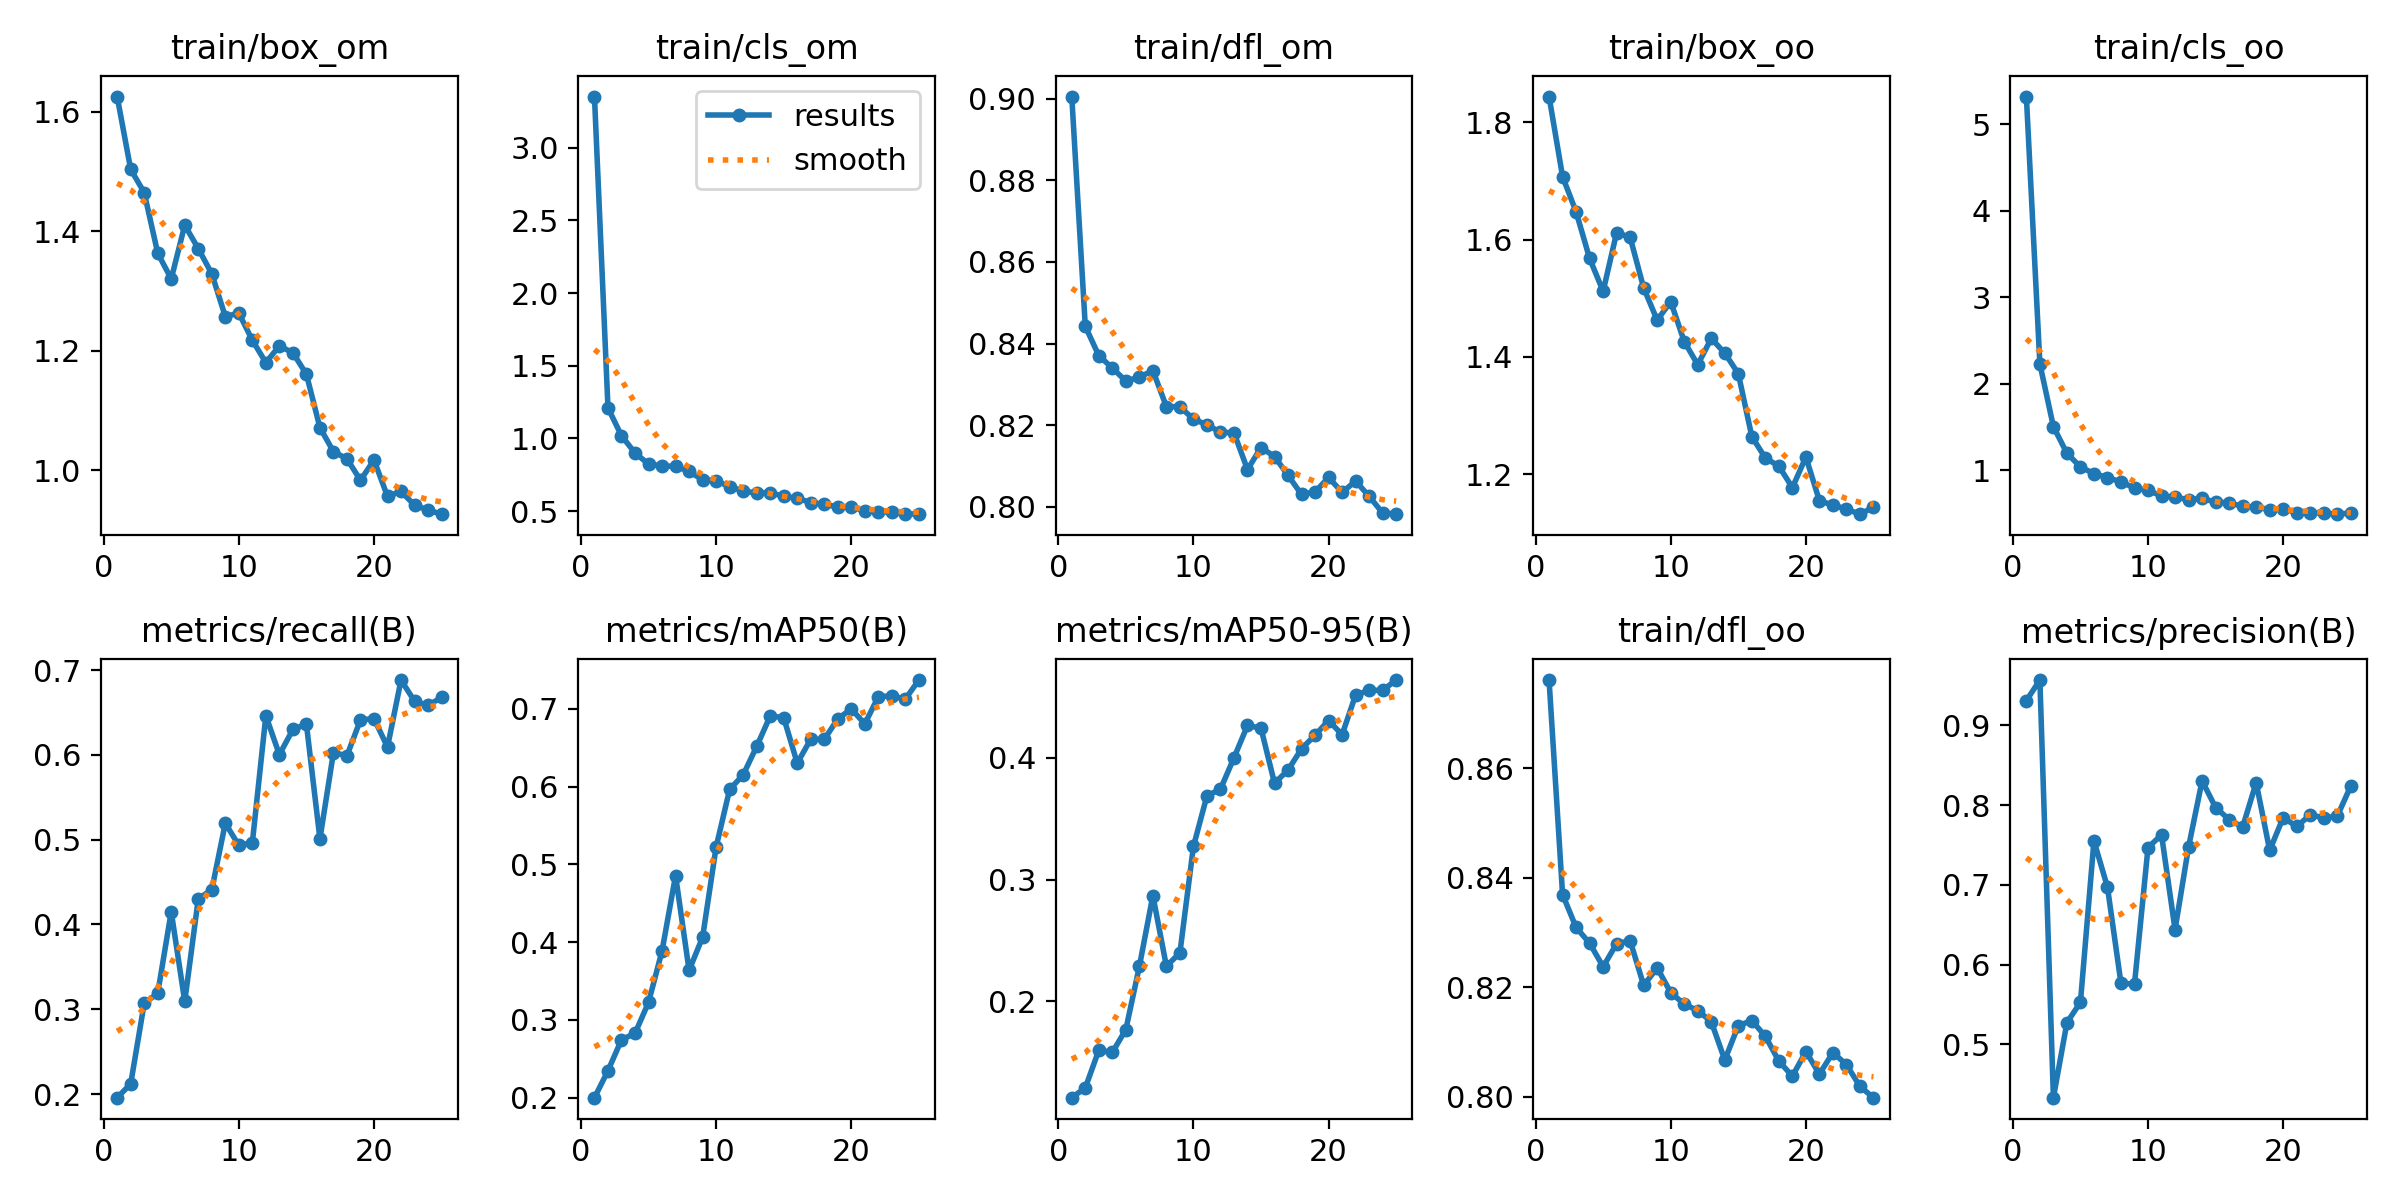

In [34]:
from IPython.display import Image

Image(filename=f"/content/yolov10/runs/detect/train2/results.png", width=1000)

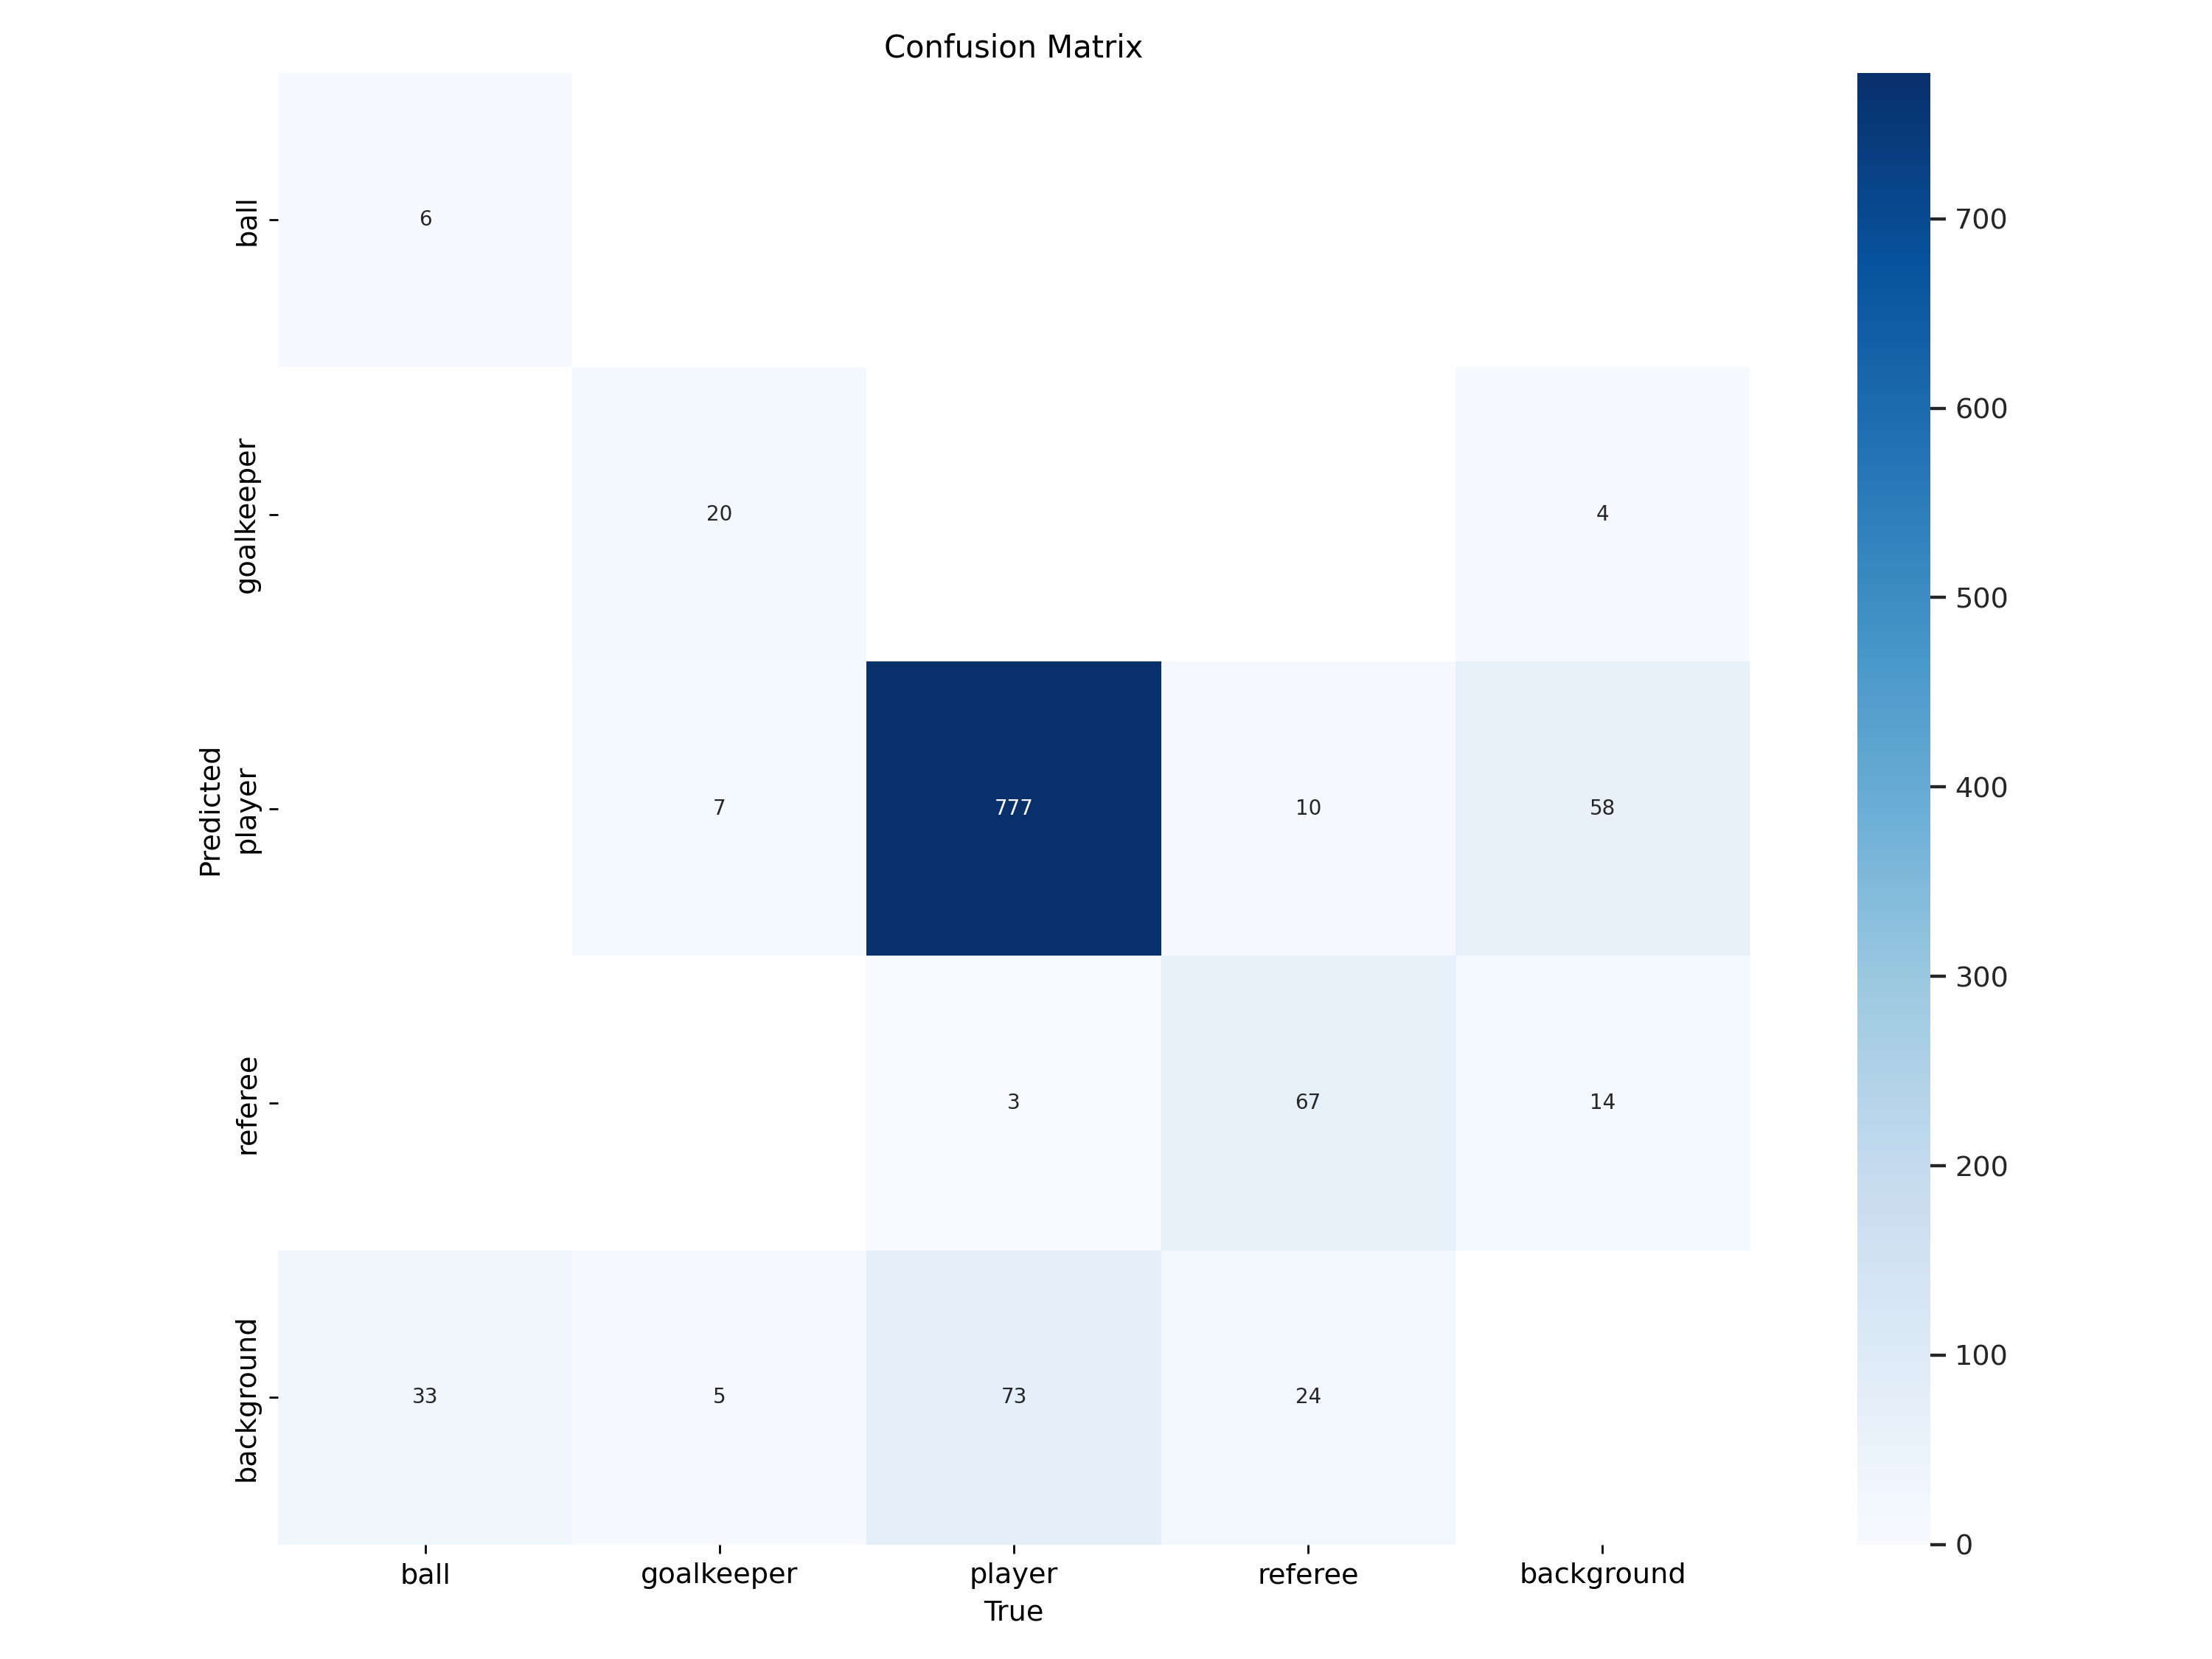

In [35]:
from IPython.display import Image

Image(filename=f"/content/yolov10/runs/detect/train2/confusion_matrix.png", width=1000)

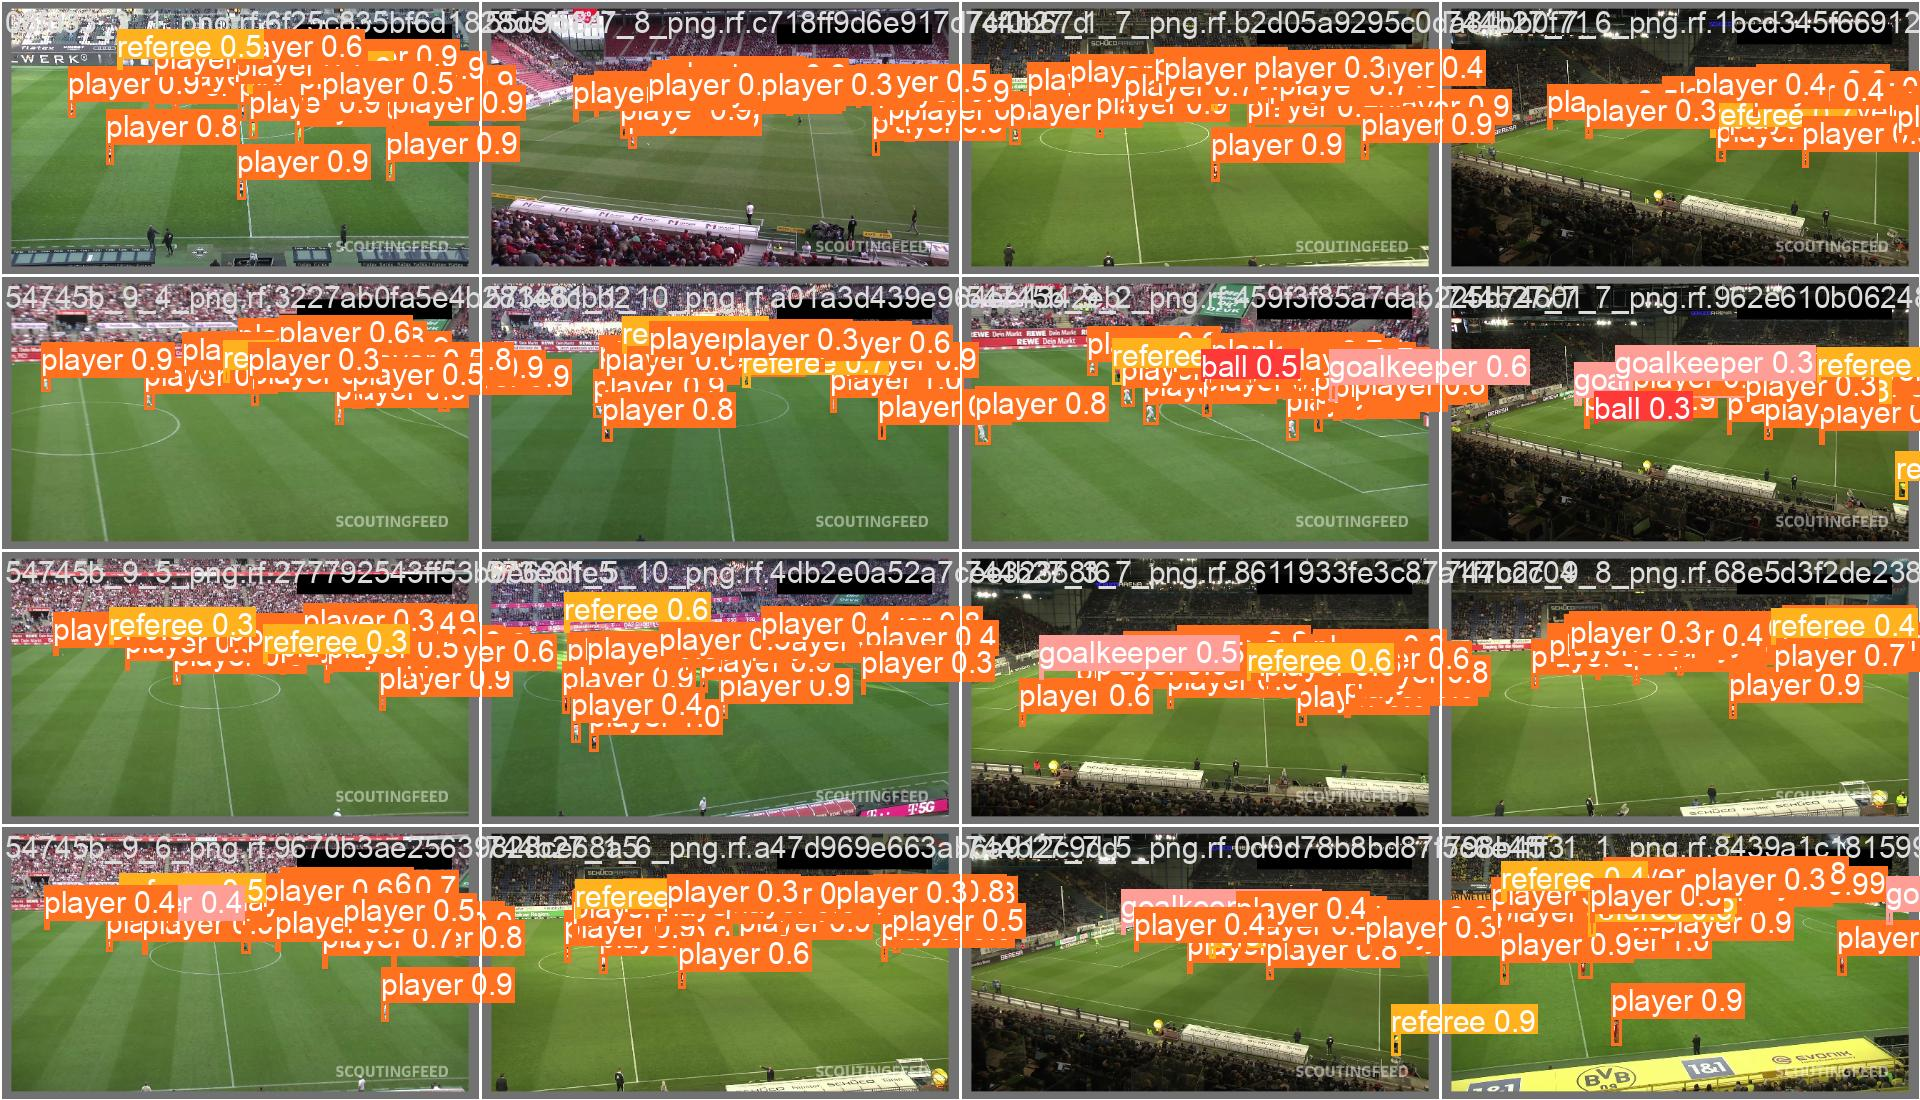

In [36]:
from IPython.display import Image

Image(filename=f"/content/yolov10/runs/detect/train2/val_batch0_pred.jpg", width=1000)

## Validate Custom Model

In [38]:
%cd {HOME}/yolov10

model.val(data=f'{dataset.location}/data.yaml', batch=256)

/content/yolov10
Ultralytics YOLOv8.1.34 🚀 Python-3.10.12 torch-2.0.1+cu117 CUDA:0 (Tesla T4, 15102MiB)
YOLOv10s summary (fused): 293 layers, 8038056 parameters, 0 gradients


val: Scanning /content/yolov10/football-players-detection-9/valid/labels.cache... 43 images, 0 backgrounds, 0 corrupt: 100%|██████████| 43/43 [00:00<?, ?it/s]
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.90s/it]


                   all         43       1025      0.827      0.668      0.737      0.464
                  ball         43         39          1      0.238      0.314     0.0694
            goalkeeper         43         32      0.778      0.719       0.87      0.612
                player         43        853       0.82      0.931      0.965        0.7
               referee         43        101       0.71      0.782      0.799      0.474
Speed: 0.1ms preprocess, 7.9ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /content/yolov10/runs/detect/train22


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c068917baf0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

## Inference with Custom Model

In [52]:
model = YOLOv10('/content/yolov10/runs/detect/train2/weights/best.pt')

In [53]:
# results = model.predict(f"{dataset.location}/test/images")

In [54]:
# # path to save the predictions
# results_path = f"{HOME}/yolov10/runs/detect/exp/"
# os.makedirs(results_path, exist_ok=True)
# # Display the results
# results[0].save(os.path.join(results_path, "dog.jpeg"))

In [55]:
# from IPython.display import Image

# Image(filename=f"{HOME}/yolov10/runs/detect/exp/dog.jpeg", width=600)

In [51]:
# !python detect.py \
# --img 1280 --conf 0.1 --device 0 \
# --weights {HOME}/yolov9/runs/train/exp/weights/best.pt \
# --source {dataset.location}/test/images

**NOTE:** Just like behore, the inference results have been saved in the appropriate directory inside `{HOME}/yolov9/runs/detect/`. Let's examine few of those results.

In [50]:
# import glob

# from IPython.display import Image, display

# for image_path in glob.glob(f'{HOME}/yolov9/runs/detect/exp3/*.jpg')[:2]:
#       display(Image(filename=image_path, width=600))

## BONUS: Deploy YOLOv10 Model with Inference

**NOTE:** To deploy the model and display inference results, we will need two additional packages - [`inference`](https://pypi.org/project/inference) and [`supervision`](https://pypi.org/project/supervision). Let's install and import them!

In [24]:
# import locale
# locale.getpreferredencoding = lambda: "UTF-8"

In [44]:
print(HOME)

/content


In [23]:
!pip -q install  inference supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 414.0/414.0 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.0/124.0 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 MB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.0/252.0 kB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.7/239.7 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 81.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.4/327.4 kB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━

In [25]:
import cv2

import random
import getpass

import supervision as sv
from inference import get_model

%matplotlib inline

In [26]:
from roboflow import Roboflow
rf = Roboflow(api_key="k8GpPnuVWz5RcZRU6PfC")
project = rf.project("football-players-detection-oh9rx")
version = project.version(1)

In [73]:
# version.deploy(model_type="yolov10", model_path=f"/content/yolov10/runs/detect/train2")

View the status of your deployment at: https://app.roboflow.com/projects-b9zgz/football-players-detection-oh9rx/1
Share your model with the world at: https://universe.roboflow.com/projects-b9zgz/football-players-detection-oh9rx/model/1


**NOTE:** Now we can download our model anywhere using the assigned `model_id` denoted by `[2]`. In my case `football-players-detection-3zvbc/6`. To download the model you will need your [`ROBOFLOW_API_KEY`](https://docs.roboflow.com/api-reference/authentication).




In [27]:
ROBOFLOW_API_KEY = "k8GpPnuVWz5RcZRU6PfC"

model = get_model(model_id="football-players-detection-oh9rx/1", api_key=ROBOFLOW_API_KEY)

**NOTE:** Let's pick random image from our test subset and detect objects using newly fine-tuned model.

In [28]:
image_paths = sv.list_files_with_extensions(
    directory=f"{dataset.location}/test/images",
    extensions=['png', 'jpg', 'jpeg']
)

In [29]:
image_path = random.choice(image_paths)
image = cv2.imread(str(image_path))

result = model.infer(image, confidence=0.1)[0]
detections = sv.Detections.from_inference(result)

**NOTE:** Finally, let's use supervision and [annotate](https://supervision.roboflow.com/develop/annotators/) our results.

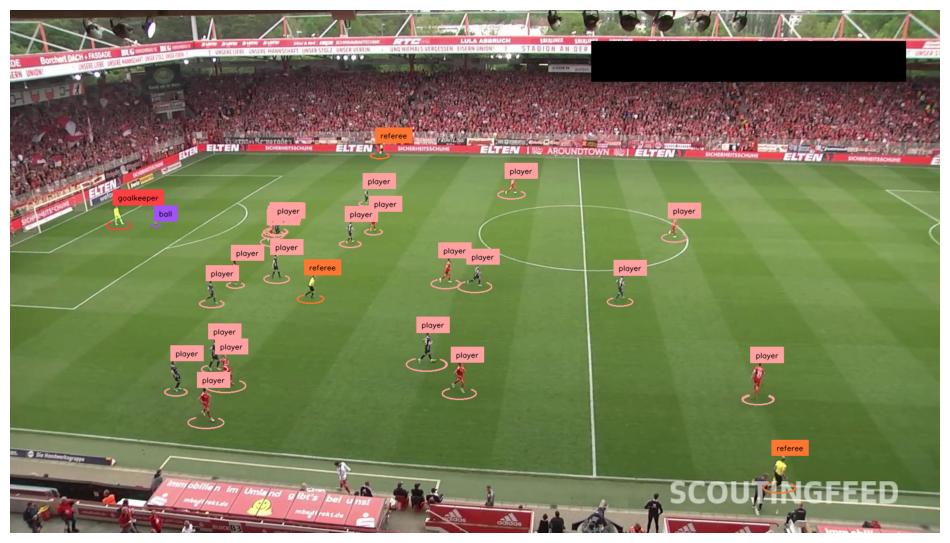

In [31]:
label_annotator = sv.LabelAnnotator(text_color=sv.Color.BLACK)
# bounding_box_annotator = sv.BoundingBoxAnnotator()
ellipse_annotator = sv.EllipseAnnotator()

annotated_image = image.copy()
# annotated_image = bounding_box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = ellipse_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

## Using Video as Input

In [42]:
import cv2

from google.colab.patches import cv2_imshow

In [62]:
video_source_path = "/content/08fd33_4.mp4"

In [63]:
frame_generator = sv.get_video_frames_generator(source_path = video_source_path)
video_info = sv.VideoInfo.from_video_path(video_path = video_source_path)

In [64]:
video_info

VideoInfo(width=1920, height=1080, fps=25, total_frames=750)

In [55]:
CONFIDENCE_THRESHOLD = 0.1
IOU_THRESHOLD = 0.5

ELLIPSE_ANNOTATOR = sv.EllipseAnnotator()
LABEL_ANNOTATOR = sv.LabelAnnotator()
TRACE_ANNOTATOR = sv.TraceAnnotator()

tracker = sv.ByteTrack()

In [65]:
with sv.VideoSink(target_path='/content/BB_08fd33_4.mp4', video_info=video_info) as sink:
  for frame in frame_generator:
      results = model.infer(frame,
                          confidence = CONFIDENCE_THRESHOLD,
                          iou_threshold = IOU_THRESHOLD
                          )[0]

      detections = sv.Detections.from_inference(results)
      detections = tracker.update_with_detections(detections)

      annotated_frame = frame.copy()

      annotated_frame = ELLIPSE_ANNOTATOR.annotate(scene=annotated_frame, detections=detections)

      labels = [
          f"#{tracker_id}" for tracker_id in detections.tracker_id
      ]

      annotated_frame = LABEL_ANNOTATOR.annotate(scene=annotated_frame,
                                                detections=detections,
                                                labels=labels)
      annotated_frame = TRACE_ANNOTATOR.annotate(
            scene=annotated_frame,
            detections=detections)

      sink.write_frame(frame=annotated_frame)